#EmDet

Purpose of this project is to build an NLP model to predict the emotion

## Get Data

In [340]:
!wget https://raw.githubusercontent.com/egehanasal/Emotion-Detection-From-Text/main/data/Cleaned%20Data/emotion_data_cleaned.csv

--2021-10-23 00:58:25--  https://raw.githubusercontent.com/egehanasal/Emotion-Detection-From-Text/main/data/Cleaned%20Data/emotion_data_cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4538038 (4.3M) [text/plain]
Saving to: ‘emotion_data_cleaned.csv’

emotion_data_cleane 100%[===================>]   4.33M  --.-KB/s    in 0.07s   

2021-10-23 00:58:25 (58.2 MB/s) - ‘emotion_data_cleaned.csv’ saved [4538038/4538038]



In [341]:
import pandas as pd
df = pd.read_csv("emotion_data_cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    59885 non-null  object
 1   target  60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


## Preprocess data

In [342]:
import numpy as np
np.where(pd.isnull(df))

(array([  659,   664,  3181,  4865,  4933,  5230,  5473,  6451,  6838,
         6914,  7143,  7475,  8081,  8216,  8707,  8837,  9169,  9229,
         9920, 10882, 11111, 11145, 11289, 12098, 12275, 12867, 13810,
        13986, 14100, 15232, 15432, 15941, 16054, 16698, 16808, 18020,
        18153, 18577, 20502, 20665, 20973, 22569, 22776, 23415, 25049,
        25410, 25497, 25527, 26255, 26782, 27122, 27680, 27877, 28789,
        28824, 28972, 29208, 29372, 29783, 30257, 30380, 31109, 31852,
        32122, 32147, 32153, 33123, 33729, 33816, 33849, 34886, 34952,
        38438, 38650, 39206, 39518, 39995, 40659, 40664, 43181, 44865,
        44933, 45230, 45473, 46451, 46838, 46914, 47143, 47475, 48081,
        48216, 48707, 48837, 49169, 49229, 49920, 50882, 51111, 51145,
        51289, 52098, 52275, 52867, 53810, 53986, 54100, 55232, 55432,
        55941, 56054, 56698, 56808, 58020, 58153, 58577]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0

In [343]:
np.where(df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

Drop the null lines and check the data again

In [344]:
df.dropna(inplace=True)

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59885 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    59885 non-null  object
 1   target  59885 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [346]:
df.head(10)

,text,target
0,i know i was listenin to bad habit earlier and...,empty
1,Layin n bed with a headache ughhhh...waitin on...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,We want to trade with someone who has Houston ...,neutral
5,Re-pinging why didn't you go to prom? BC my bf...,worry
6,"I should be sleep, but im not! thinking about ...",sadness
7,Hmmm. http://www.djhero.com/ is down,worry
8,Charlene my love. I miss you,sadness
9,I'm sorry at least it's Friday?,sadness


In [347]:
# Distribution of labels in training data
df.target.value_counts()

sadness       10946
neutral        8582
worry          8454
joy            6747
love           5481
happiness      5208
surprise       2904
anger          2814
fear           2369
fun            1776
relief         1526
hate           1323
empty           816
enthusiasm      759
boredom         179
jo                1
Name: target, dtype: int64

Let's delete the rows with targets "jo, boredom, enthusiasm, empty" since they have less examples compared to others

In [348]:
df.drop(df[df["target"] == "jo"].index, inplace=True)
df.drop(df[df["target"] == "boredom"].index, inplace=True)
df.drop(df[df["target"] == "enthusiasm"].index, inplace=True)
df.drop(df[df["target"] == "empty"].index, inplace=True)

In [349]:
df["target"].value_counts()

sadness      10946
neutral       8582
worry         8454
joy           6747
love          5481
happiness     5208
surprise      2904
anger         2814
fear          2369
fun           1776
relief        1526
hate          1323
Name: target, dtype: int64

Before splitting our data, let's shuffle it.

In [350]:
# Shuffle the dataframe
df_shuffled = df.sample(frac=1)
df_shuffled.head(10)

,text,target
11891,friend got mugged this morning,sadness
55187,your not talking about your obsession with me ...,joy
34599,just missing you&amp;hoping to talk to you soo...,happiness
37506,Okay I'm about to &quot;crawl&quot; into bed a...,neutral
12173,I don't know what im doing :S,worry
51520,Practically my whole body burns... I can't ben...,joy
10782,http://twitpic.com/676tn - Home Sweet Home... ...,happiness
56081,yeah text me!!! i wnat to go!!!!! but my car i...,love
50157,so no rice or crusty bread with the chili .......,sadness
26121,ill and bored on bank holiday.. Nothings open....,sadness


### Split the data to train, val and test sets

In [351]:
from sklearn.model_selection import train_test_split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(df_shuffled["text"].to_numpy(),
                                                                          df_shuffled["target"].to_numpy(),
                                                                          test_size=0.15)

In [352]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences,
                                                                        train_labels,
                                                                        test_size=0.1)

In [353]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels), len(test_sentences), len(test_labels)

(44469, 44469, 4941, 4941, 8720, 8720)

In [354]:
# View first 10 lines of training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(["just saw an advert for ATTICS TO EDEN on tv out today and only ï¿½9.99 from HMV...so I'm not sure why I had to pay ï¿½13 at HMV...never mind",
        "is my son - he gets my vote today coz he has grown into a loving, caring 'soul-full' man - who loves his mum",
        'oh about you lol sorry my minds always on you', 'My eyes hurt',
        "WOMAN, I didn't know you came home you so suck!!! When are you going back!",
        'On the way to Wildomar, CA towing the Lexus',
        "I'll be back home on Monday.",
        'I think we all need a oil change wash and wax every now and again',
        'i wanna see her hair hows everyone?',
        ':O Looking through my old stuff and found a record from my old band! Well,a band that I was in for about a month. Ever heard of ?'],
       dtype=object),
 array(['relief', 'neutral', 'surprise', 'neutral', 'joy', 'sadness',
        'neutral', 'neutral', 'worry', 'sadness'], dtype=object))

## Make numeric labels

We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels 

To numerically encode labels we'll use Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes.



### One hot encode labels

In [355]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_labels.reshape(-1,1))

In [356]:
train_labels_one_hot, train_labels_one_hot.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), (44469, 12))

### Label encode labels

In [357]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [358]:
val_labels_encoded, val_labels_encoded.shape

(array([ 9,  6,  0, ...,  1, 11, 10]), (4941,))

In [359]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(12, array(['anger', 'fear', 'fun', 'happiness', 'hate', 'joy', 'love',
        'neutral', 'relief', 'sadness', 'surprise', 'worry'], dtype=object))

## Starting a Series of Modelling Experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

## Model 0: Getting a baseline

Our first model will be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, we'll create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) aglorithm.

In [360]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf_idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [361]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.22384132766646428

In [362]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([9, 9, 9, ..., 9, 9, 9])

### Download helper function script

In [363]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-23 00:58:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-23 00:58:28 (80.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [364]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results2(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision*100,
                  "recall": model_recall*100,
                  "f1": model_f1*100}
  return model_results

In [365]:
from helper_functions import calculate_results

In [366]:
# Calculate baseline results
baseline_results = calculate_results2(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 22.384132766646427,
 'f1': 14.277496460870474,
 'precision': 19.88909756815203,
 'recall': 22.384132766646427}

## Preparing the data for deep sequence models

In [367]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [368]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len 

12.948885740628302

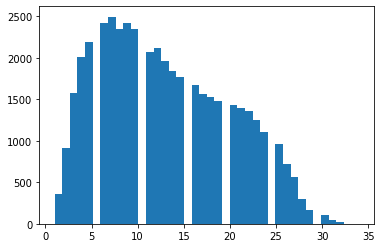

In [369]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=40);

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's [`percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) to find the value which covers 95% of the sentence lengths.

In [370]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

25

It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 25 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

## Create text vectorizer layer

To do so, we'll use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer from TensorFlow.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

In [371]:
# How many words are in our vocab?
from collections import Counter
results = Counter()
df["text"].str.lower().str.split().apply(results.update)
len(results)

56429

In [372]:
max_tokens = 56000

In [373]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [374]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [375]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"Length of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
i miss coffee
Length of text: 3

Vectorized text:
[[  2  70 433   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]]


In [376]:
# How many words in our training vocabulary
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Most common words in vocab: {text_vocab[:5]}")
print(f"Least common words in vocab: {text_vocab[-5:]}")

Number of words in vocab: 33117
Most common words in vocab: ['', '[UNK]', 'i', 'to', 'the']
Least common words in vocab: ['024', '010', '002', '0003', '00']


In [377]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 56000,
 'name': 'text_vectorization_6',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 25,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

In [378]:
# Create custom text embedding
token_embed = layers.Embedding(input_dim=len(text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [379]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentece after vectorization (before the embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentece after embedding: {embedded_sentence}\n")
print(f"Embedded sentece shape: {embedded_sentence.shape}")

Sentence before vectorization:
i miss coffee

Sentece after vectorization (before the embedding):
[[  2  70 433   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]]

Sentece after embedding: [[[ 9.2338771e-05 -1.7381370e-02 -3.1811439e-02 ...  2.3088183e-02
   -3.9630093e-02 -1.7506849e-02]
  [-4.6393860e-02  2.3282614e-02  2.0070497e-02 ... -4.0197253e-02
   -4.5490742e-02 -1.4603674e-02]
  [-2.8728986e-02 -4.3805946e-02  7.9753287e-03 ...  1.0866262e-02
   -1.4313530e-02  3.3111405e-02]
  ...
  [ 3.6201645e-02 -1.0732077e-02  4.4356573e-02 ...  4.4851433e-02
    3.4150515e-02  1.5451793e-02]
  [ 3.6201645e-02 -1.0732077e-02  4.4356573e-02 ...  4.4851433e-02
    3.4150515e-02  1.5451793e-02]
  [ 3.6201645e-02 -1.0732077e-02  4.4356573e-02 ...  4.4851433e-02
    3.4150515e-02  1.5451793e-02]]]

Embedded sentece shape: (1, 25, 128)


## Creating datasets (making sure our data loads as fast as possible)

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [380]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (12,)), types: (tf.string, tf.float64)>

In [381]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D with token embeddings

In [382]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.MaxPooling1D(pool_size=2, padding="valid")(x)
x = layers.MaxPooling1D(pool_size=2, padding="valid")(x)
x = layers.GlobalAveragePooling1D()(x)  #condense the output of our vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [383]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [384]:
# Get a summary of the model
model_1.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_6 (TextVe (None, 25)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 25, 128)           4238976   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 25, 64)            41024     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
global_average_pooling1d_17  (None, 64)                0  

In [385]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=3,
                              validation_data=val_dataset)

Epoch 1/3
1390/1390 [==============================] - 17s 12ms/step - loss: 2.1687 - accuracy: 0.2518 - val_loss: 2.1076 - val_accuracy: 0.2763
Epoch 2/3
1390/1390 [==============================] - 16s 11ms/step - loss: 1.9649 - accuracy: 0.3269 - val_loss: 2.1693 - val_accuracy: 0.2657
Epoch 3/3
1390/1390 [==============================] - 16s 11ms/step - loss: 1.7065 - accuracy: 0.4178 - val_loss: 2.3888 - val_accuracy: 0.2338
